<a href="https://colab.research.google.com/github/chimpchimpo21/gtech731/blob/main/nyc_streets_quality.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Final Project Code Appendix

In order to verify all of the code below, please load the following in the environment at the start:
 - nyc_zips.geojson     (zip code polygons)
 - acs_income.csv       (ACS income data)
 - nyc_acs_sar.geojson  (Street assessments joined to ACS data)
 - nyc_sar_wgs.geojson  (WGS84-projected street assessment data)

The web map visualizations can be viewed by opening the following two html files in a browser:
 - nyc_street_quality_zip_level_FINAL.html (street assessment / income by ZIP)
 - nyc_street_quality.html (ALL-NYC street segments quality by borough)

###Section 1 : load relevant libraries and packages

In [ ]:
!pip install geopandas
!pip install rtree
!pip install mapclassify

In [ ]:
import glob                                                                     #read-in json files
import math                                                                     #calculations
import geopandas as gpd                                                         #geodataframes
import pandas as pd                                                             #dataframe processing/analysis
import numpy as np                                                              #calculations/processing
import matplotlib.pyplot as plt                                                 #map/graph plotting
import rtree                                                                    #spatial joins
from mpl_toolkits.axes_grid1 import make_axes_locatable                         #set plot legend height equal to plot height
import mapclassify                                                              #grouped choropleth maps
from osgeo import ogr                                                           #gdal geometries
import folium                                                                   #interactive map visualization
from folium.plugins import Search                                               #map search box
import branca                                                                   #colormaps for map visualization

###Section 2 : data load and preparation <br>

Part 1 - street assessment data <br>
 - read and process street segment data pertaining to street <br>
   assessment rating

1a: read-in JSON data

In [ ]:
#Read in the current json files in the working directory
jsons = glob.glob("*.json")
#create a geodataframe as a concatenation of all the json files read in as geodataframes
df = pd.concat([gpd.read_file(each) for each in jsons], ignore_index = True)

In [ ]:
#check data type of the df object
type(df)

geopandas.geodataframe.GeoDataFrame

In [ ]:
#visualize the dataframes rows/columns
print(df.head(10))
#print the column names
print(df.columns)

  Length  ...                                           geometry
0    300  ...  LINESTRING (938840.000 155464.000, 938842.559 ...
1    288  ...  LINESTRING (944843.000 147825.000, 944887.000 ...
2    300  ...  LINESTRING (939701.000 141051.000, 939635.000 ...
3    288  ...  LINESTRING (936424.000 139699.000, 936467.000 ...
4    291  ...  LINESTRING (938628.000 136351.000, 938390.000 ...
5    278  ...  LINESTRING (938455.000 140041.000, 938199.000 ...
6    284  ...  LINESTRING (939757.000 140258.000, 939789.000 ...
7    291  ...  LINESTRING (938199.000 139997.000, 937947.000 ...
8    286  ...  LINESTRING (941878.000 140227.000, 941617.000 ...
9    276  ...  LINESTRING (925305.000 135645.000, 925290.000 ...

[10 rows x 6 columns]
Index(['Length', 'Rating_B', 'RatingWord_B', 'RatingFY_SA', 'Shape_Length',
       'geometry'],
      dtype='object')


1b: validate segment data with plot

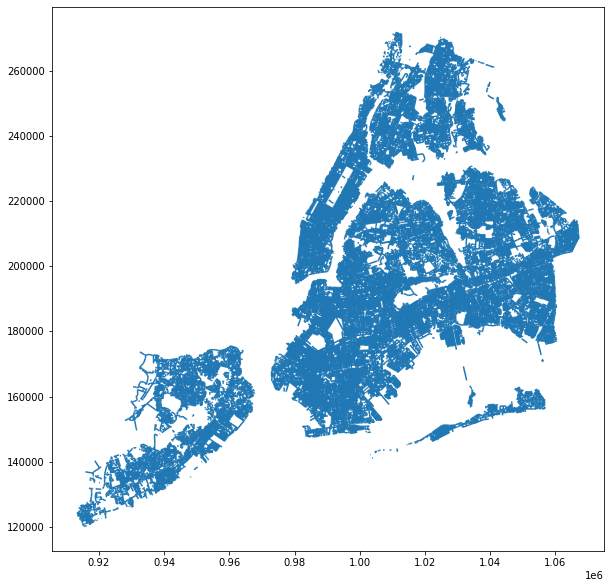

In [ ]:
#plot the df
geo = gpd.GeoSeries(df['geometry'])
geo.plot(figsize = (10,10))
plt.savefig('nyc_sar_orig.png')   #save png image
plt.show()

1c: validate transformed segment data with plot

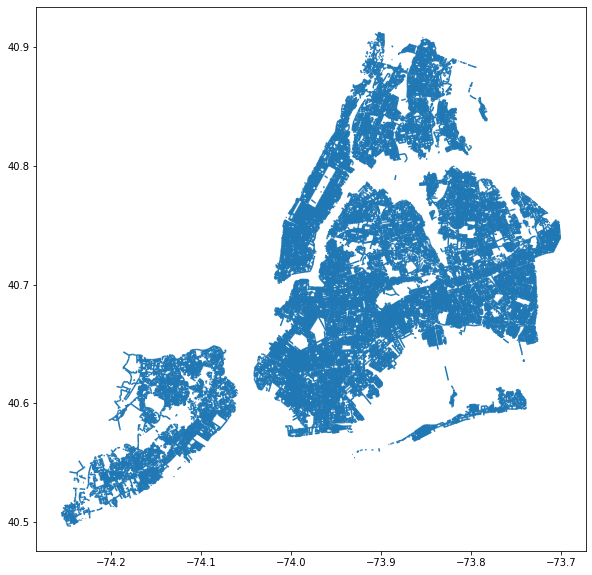

In [ ]:
#reproject df to wgs84
df_wgs = df.to_crs("EPSG:4326")
#plot wgs84 projected data
df_wgs.plot(figsize = (10,10))
plt.savefig('nyc_sar_orig_wgs')   #save png image
plt.show()

1d: validate rating column data with plot

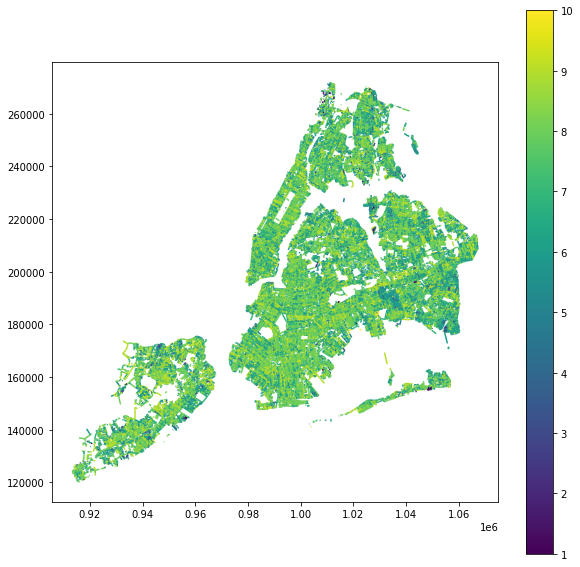

In [ ]:
#plot data by street assessment numerical score(1-10)
df.plot(column='Rating_B', figsize = (10,10), legend=True)
plt.savefig('sar_score')
plt.show()

1e: validate qualitative rating column with plot

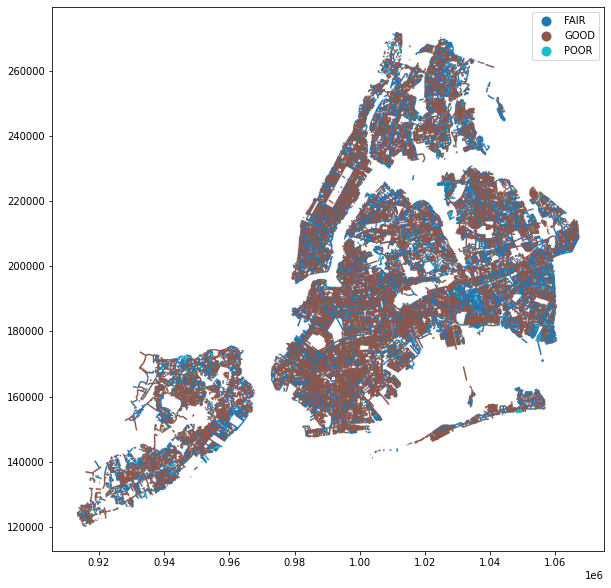

In [ ]:
#plot data by street assessment qualitative score(poor, fair, good)
df.plot(column='RatingWord_B', figsize = (10,10), legend=True)
plt.savefig('sar_word.png')
plt.show()

In [ ]:
#write both street assessment df to geojson files
df.to_file("nyc_sar.geojson", driver="GeoJSON")
df_wgs.to_file("nyc_sar_wgs.geojson", driver="GeoJSON")

Part 2 - zip code polygons <br>
  - read in zipcode polygons

2a: read-in GeoJSON data

In [ ]:
#read-in file
nyc_zip = gpd.read_file("nyc_zips.geojson")

2b: validate data

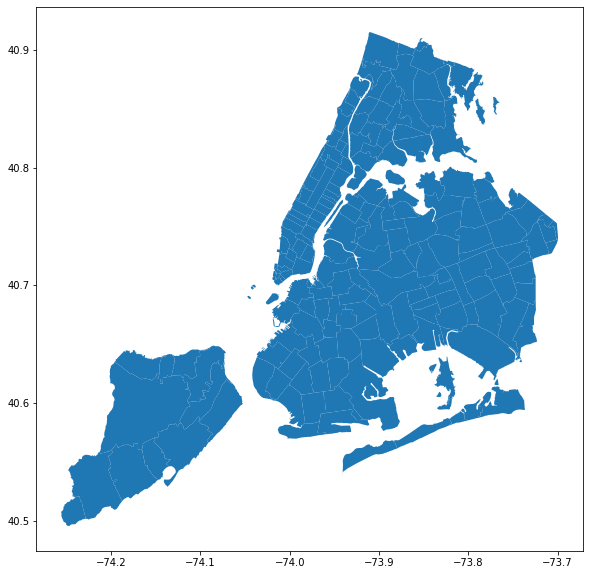

In [ ]:
#check file
nyc_zip
#check crs
nyc_zip.crs #[epsg:4326]
#plot data
nyc_zip.plot(figsize = (10,10))
plt.show()

Part 3 - acs income data <br>
  - read in acs data and join to zip codes

3a: read-in csv data

In [ ]:
#read-in file
acs = pd.read_csv("acs_income.csv", dtype=object)

###Section 3: data processing

Part 1: join zipcode polygons to acs data, eliminate empty rows, then further cleaning of median income column

In [ ]:
#joining zip codes with acs data and cleaning up the resultant dataframe
#check file
acs
#join acs data to zipcode data by matching zipcode
nyc_acs = nyc_zip.merge(acs, how="left", left_on="postalCode", right_on="zip")
#check join
nyc_acs
type(nyc_acs)
nyc_acs.crs
#drop unnecessary columns
nyc_acs = nyc_acs.drop(columns=["STATE", "BLDGpostal", "@id"])
nyc_acs
#remove rows with NaN values
nyc_acs = nyc_acs.dropna(subset=['zip'])
nyc_acs
#edit median income column data type and missing values
#this single building/block zipcodes mostly in manhattan
#also edits one income column for a zipcode that had median income above $250,000
nyc_acs['median_income'] = np.where((nyc_acs['median_income'] == '-'), 0, nyc_acs['median_income'])
nyc_acs['median_income'] = np.where((nyc_acs['median_income']=='250,000+'), 250000, nyc_acs['median_income'])
nyc_acs = nyc_acs[nyc_acs.median_income != 0]
#convert median income column to type integer
nyc_acs['median_income'] = nyc_acs['median_income'].astype(str).astype(int)
nyc_acs.dtypes
#plot check
nyc_acs.plot(figsize = (10,10))
plt.show()

Part 2 - spatial join <br>
 - overlay/union street segments to zip code polygons, dataframe validation

In [ ]:
#read-in street assessment geojson
nyc_sar = gpd.read_file("nyc_sar_wgs.geojson")
#check file
type(nyc_sar)
nyc_sar
nyc_sar.crs
#spatial join street segments to nyc_acs dataframe
#want to get the zipcodes of each street segment,
#need to get linestrings of streets split by the zipcode polygons
#using overlay of lines with polygons and "union operation"
zip_streets = gpd.overlay(nyc_sar, nyc_acs, how='union').explode().reset_index(drop=True)
#check to see how many segments dont have acs data
testNA = zip_streets.dropna(subset=['ST_FIPS'])  #drops 1,299 segments that dont
                                                 #have any acs/zip data associated
zip_streets = testNA
#plot check
zip_streets.plot(figsize = (12,12))
plt.show()
#save as geojson
zip_streets.to_file('zip_streets.geojson', driver="GeoJSON")

###Section 4 : analysis <br>

Part 1 - calculate averages
- average street quality score for each zipcode <br>
- average year of assessment for street segments for each zipcode

In [ ]:
#group by zipcode column and calculate mean of street assessment score and
#mean of year streets were assessed in each zipcode
list(zip_streets.columns)
sar_mean_table = zip_streets.groupby('zip')['Rating_B'].mean()
sar_mean_table
sar_year_mean = zip_streets.groupby('zip')['RatingFY_SA'].mean()
sar_year_mean
#join tables to the acs/zipcode dataframe
nyc_acs_sar = nyc_acs.merge(sar_mean_table, how="left", left_on='zip', right_on='zip')
nyc_acs_sar = nyc_acs_sar.merge(sar_year_mean, how='left', left_on='zip', right_on='zip')
#eliminate decimals from street assessment rating year column
nyc_acs_sar['RatingFY_SA'] = np.floor(pd.to_numeric(nyc_acs_sar['RatingFY_SA'], errors='coerce')).astype('Int64')

In [ ]:
#save the resultant dataframe as a geojson
nyc_acs_sar.to_file("nyc_acs_sar.geojson", driver='GeoJSON')

Part 2a - calculate average street score for each borough

In [ ]:
#nyc_acs_sar = gpd.read_file('nyc_acs_sar.geojson')

In [ ]:
#look over the now combined geodataframe at some of the summary statistics
nyc_acs_sar.describe()

,OBJECTID,longitude,latitude,median_income,Rating_B,RatingFY_SA
count,195.000000,195.000000,195.000000,195.000000,193.000000,193.000000
mean,103.441026,-73.913167,40.725237,79587.384615,7.371152,2019.067358
std,62.709364,0.102479,0.084170,39777.203692,0.368372,0.604343
min,1.000000,-74.242235,40.507964,21447.000000,6.000000,2016.000000
25%,50.500000,-73.978681,40.671019,54265.500000,7.220741,2019.000000
50%,102.000000,-73.920819,40.726538,70793.000000,7.432258,2019.000000
75%,152.500000,-73.843070,40.777851,95569.000000,7.600605,2019.000000
max,262.000000,-73.703443,40.901100,250000.000000,8.454545,2021.000000


In [ ]:
#group by borough column and calculate mean of street assessment score
sar_borough_mean = nyc_acs_sar.groupby('borough')['Rating_B'].mean()

In [ ]:
sar_borough_mean

borough
Bronx            7.152071
Brooklyn         7.588126
Manhattan        7.486432
Queens           7.260667
Staten Island    7.323725
Name: Rating_B, dtype: float64

Part 2b - calculate average year assessed for each borough

In [ ]:
#group by borough column and calculate mean of street assessment score
sar_borough_year_mean = nyc_acs_sar.groupby('borough')['RatingFY_SA'].mean()

In [ ]:
sar_borough_year_mean

borough
Bronx            2018.821429
Brooklyn         2018.948718
Manhattan        2019.333333
Queens           2019.060606
Staten Island    2019.000000
Name: RatingFY_SA, dtype: float64

In [ ]:
#read-in latest geojson files:
#zip codes/acs data/street quality avg.
#nyc_acs_sar = gpd.read_file('nyc_acs_sar.geojson')
#street segments for each zipcode
#zip_streets = gpd.read_file('zip_streets.geojson')

Part 3 - Street quality ratings within zipcodes <br>
  - identify each zipcodes street segments by their individual quality score
  - take each sub-group and create geometries within each zipcode
  - calculate the percentage of each score within each zipcode

In [ ]:
#view the columns of the dataframe
zip_streets.dtypes

In [ ]:
#drop unecessary columns
zip_streets_only = zip_streets.drop(columns=['postalCode', 'ST_FIPS', 'CTY_FIPS', 'longitude', 'latitude', 'id'])

3a: create geodataframes of street segments with particular quality scores

In [ ]:
#create dataframes of each all segments of distinct street assessment scores
#length of each resulting dataframe to ensure all rows of input dataframe are accounted for
st_1 = zip_streets[zip_streets['Rating_B'] == 1.0]
print(len(st_1))
st_2 = zip_streets[zip_streets['Rating_B'] == 2.0]
print(len(st_2))
st_3 = zip_streets[zip_streets['Rating_B'] == 3.0]
print(len(st_3))
st_4 = zip_streets[zip_streets['Rating_B'] == 4.0]
print(len(st_4))
st_5 = zip_streets[zip_streets['Rating_B'] == 5.0]
print(len(st_5))
st_6 = zip_streets[zip_streets['Rating_B'] == 6.0]
print(len(st_6))
st_7 = zip_streets[zip_streets['Rating_B'] == 7.0]
print(len(st_7))
st_8 = zip_streets[zip_streets['Rating_B'] == 8.0]
print(len(st_8))
st_9 = zip_streets[zip_streets['Rating_B'] == 9.0]
print(len(st_9))
st_10 = zip_streets[zip_streets['Rating_B'] == 10.0]
print(len(st_10))

87
145
961
5
3952
15501
14519
26932
15387
133


3b: transformation <br>
There are now 10 geodataframes, each contains the street segments of a particular street quality score (1 - 10). <br>
Because the scale of analysis is now at the street level, each geodataframe <br>
will be reprojected to EPSG 2263 (NAD83 State Plane Long Island).
The street <br> quality score of '4' geodataframe will be used as a trial, as it contains only 5 segments.

In [ ]:
#re-project from WGS84 to SP Long Island
st_4_sp = st_4.to_crs('EPSG:2263')
#check projection
st_4_sp.crs

In [ ]:
#reproject the rest of the street score dataframes
st_1_sp = st_1.to_crs('EPSG:2263')
st_2_sp = st_2.to_crs('EPSG:2263')
st_3_sp = st_3.to_crs('EPSG:2263')
st_5_sp = st_5.to_crs('EPSG:2263')
st_6_sp = st_6.to_crs('EPSG:2263')
st_7_sp = st_7.to_crs('EPSG:2263')
st_8_sp = st_8.to_crs('EPSG:2263')
st_9_sp = st_9.to_crs('EPSG:2263')
st_10_sp = st_10.to_crs('EPSG:2263')

3c: function using GDAL/OGR to calculte segment lengths

In [ ]:
#This is a function to create gdal/ogr geometries for each row's geometry of
#the input dataframe. There is a print to give the lengths of each segment
#**this will be turned off for larger dataframes
def calcLength(gdf):                                                            #takes a geodataframe as input
 gdf['len'] = np.nan                                                            #create empty length column to populate
 for index, row in gdf.iterrows():                                              #iterates through the rows
  wkt = str(row.geometry)                                                       #sets the row's geometry column to a variable
  geom = ogr.CreateGeometryFromWkt(wkt)                                         #creates the ogr geometry object
  len = geom.Length()                                                           #save the object length to a variable
  gdf.at[index, 'len'] = len                                                    #set the empty columns value to the geometry length
  #print(wkt)                                                                   #test to see if wkt set correctly
  #print(geom.Length())                                                         #test to see if ogr object correctly created
  #print("Length = %d" % geom.Length())                                         #print's the geometry's length


In [ ]:
#testing function to make sure it works by working with the smallest score geodataframe (5 entries)
calcLength(st_4_sp)

In [ ]:
#use GDAL to create geometries of each of the score-specific geodataframes
calcLength(st_1_sp)
calcLength(st_2_sp)
calcLength(st_3_sp)
calcLength(st_5_sp)
calcLength(st_6_sp)
calcLength(st_7_sp)
calcLength(st_8_sp)
calcLength(st_9_sp)
calcLength(st_10_sp)

3d: <br>
 - append geodataframes
 - calculate total segment lengths (in miles) for each score for all NYC
 - calculate segment lengths (in feet) for each score per zipcode
 - calculate total assessed street segment lengths (in feet) for each zipcode

In [ ]:
#combine the 10 dataframes back together
#append all the dataframes together
df_list = [st_2_sp, st_3_sp, st_4_sp, st_5_sp, st_6_sp, st_7_sp, st_8_sp, st_9_sp, st_10_sp]
st_ln_score = st_1_sp
for each in df_list:
  st_ln_score = st_ln_score.append(each)
#check
st_ln_score
#save as geojson
st_ln_score.to_file('st_ln_score.geojson', driver="GeoJSON")
#calculate the sum of all segment lengths (in miles) in each score
score_len = st_ln_score.groupby(['Rating_B'])[['len']].sum()/5280
print(score_len)
#group each dataframe by zipcode and score and sum the lengths of segments
zip_score_len2 = st_ln_score.groupby(['zip', 'Rating_B'])[['len']].sum().unstack()
print(zip_score_len2)
#group each dataframe by zipcode and get the total length (ft) of all assessed
#street segments per zipcode
zip_score_len3 = st_ln_score.groupby(['zip'])[['len']].sum()
print(zip_score_len3)

                  len
Rating_B             
1.0          4.656738
2.0          9.885120
3.0         65.741226
4.0          0.481636
5.0        266.540475
6.0       1022.281548
7.0        928.208850
8.0       1750.380562
9.0        982.332094
10.0         6.499375
                  len               ...                           
Rating_B         1.0          2.0   ...          9.0          10.0
zip                                 ...                           
10001             NaN          NaN  ...  20399.354887          NaN
10002             NaN   329.661948  ...  15286.268637          NaN
10003             NaN          NaN  ...  10123.801892          NaN
10004             NaN          NaN  ...   1634.690260          NaN
10005             NaN          NaN  ...   1164.853715          NaN
...               ...          ...  ...           ...          ...
11691     2841.795872  2889.490959  ...  31079.289476          NaN
11692      196.499364   451.775387  ...  17619.932132   530.291587

In [ ]:
#st_ln_score = gpd.read_file('st_ln_score.geojson')
#st_ln_score

3e: <br>
 - merge calculated series into main zipcode geodataframe
 - export as .csv and error check

In [ ]:
#merge zip_score_len2 to nyc_acs_sar data
zips_st_scores = nyc_acs_sar.merge(zip_score_len2, how='left', left_on='zip', right_on='zip')
#merge zip_score_len3 to nyc_acs_sar data
zips_st_scores2 = zips_st_scores.merge(zip_score_len3, how='left', left_on='zip', right_on='zip')

In [ ]:
#export dataframe as csv to look over the data
zips_st_scores2.to_csv('zip_st_scores2.csv')
#found one duplicate geometry (incorrectly geocoded zipcode [11370] in the Bronx and Queens, Queens is the correct entry)
#find and delete duplicated row in the dataframe
zips_st_scores3 = zips_st_scores2.drop([190])

Part 4: calculate percentages of scored streets in each zipcode

In [ ]:
#calculate the percentage of streets in each zipcode receiving
#a particular score compared to total assessed
#street length in the zipcode
#need to do this calculation for each street score column
#first fill all NaN values in the score columns to 0
#but need to rename tuple-based columns (from earlier summary/merge operation)
zips_st_scores3 = zips_st_scores3.rename(columns =
                                         {zips_st_scores3.columns[-2] : '10'})  #test to make sure rename will work
zips_st_scores3 = zips_st_scores3.rename(columns =
                                         {zips_st_scores3.columns[-3] : '9',
                                          zips_st_scores3.columns[-4] : '8',
                                          zips_st_scores3.columns[-5] : '7',
                                          zips_st_scores3.columns[-6] : '6',
                                          zips_st_scores3.columns[-7] : '5',
                                          zips_st_scores3.columns[-8] : '4',
                                          zips_st_scores3.columns[-9] : '3',
                                          zips_st_scores3.columns[-10] : '2',
                                          zips_st_scores3.columns[-11] : '1'})  #complete rename
#fill NaNs to 0
zips_st_scores3['1'] = zips_st_scores3['1'].fillna(0)
zips_st_scores3['2'] = zips_st_scores3['2'].fillna(0)
zips_st_scores3['3'] = zips_st_scores3['3'].fillna(0)
zips_st_scores3['4'] = zips_st_scores3['4'].fillna(0)
zips_st_scores3['5'] = zips_st_scores3['5'].fillna(0)
zips_st_scores3['6'] = zips_st_scores3['6'].fillna(0)
zips_st_scores3['7'] = zips_st_scores3['7'].fillna(0)
zips_st_scores3['8'] = zips_st_scores3['8'].fillna(0)
zips_st_scores3['9'] = zips_st_scores3['9'].fillna(0)
zips_st_scores3['10'] = zips_st_scores3['10'].fillna(0)

#create new columns with length percentages per score
zips_st_scores3['pct1'] = round((zips_st_scores3['1']/zips_st_scores3['len'])*100)
zips_st_scores3['pct2'] = round((zips_st_scores3['2']/zips_st_scores3['len'])*100)
zips_st_scores3['pct3'] = round((zips_st_scores3['3']/zips_st_scores3['len'])*100)
zips_st_scores3['pct4'] = round((zips_st_scores3['4']/zips_st_scores3['len'])*100)
zips_st_scores3['pct5'] = round((zips_st_scores3['5']/zips_st_scores3['len'])*100)
zips_st_scores3['pct6'] = round((zips_st_scores3['6']/zips_st_scores3['len'])*100)
zips_st_scores3['pct7'] = round((zips_st_scores3['7']/zips_st_scores3['len'])*100)
zips_st_scores3['pct8'] = round((zips_st_scores3['8']/zips_st_scores3['len'])*100)
zips_st_scores3['pct9'] = round((zips_st_scores3['9']/zips_st_scores3['len'])*100)
zips_st_scores3['pct10'] = round((zips_st_scores3['10']/zips_st_scores3['len'])*100)

st_ln_score_wgs = st_ln_score.to_crs('EPSG:4326')                               #convert to WGS84

#save resultant geodataframe as a geojson
zips_st_scores3.to_file('zips_st_scores3.geojson', driver='GeoJSON')            #save sp long island geojson version
st_ln_score_wgs.to_file('st_ln_score_wgs.geojson', driver='GeoJSON')            #save wgs84 geojson version


In [ ]:
#zips_st_scores3 = gpd.read_file('zips_st_scores3.geojson')
#st_ln_score_wgs = gpd.read_file('st_ln_score_wgs.geojson')

Part 5: variable normalization <br>
In order to check any initial correlation between a zipcodes streets quality and <br>
socioeconomic factors, the following variables from street segments and acs <br>
data were normalized via a min/max scalar:
 - street segment quality score
 - median income
 - mean income
 - total households (rough population density vs. streets quality correlation)

In [ ]:
#normalize variables
#will accept a panda series column and normalize the rows to values between 0 and 1
#used in scatterplots in section 5
def norm(series):
  norm_list = []
  xmin = series.min()
  xmax = series.max()
  #print(xmin, xmax)
  for idx in series:
    xnorm = (idx - xmin)/(xmax - xmin)
    norm_list.append(xnorm)
  return norm_list

###Section 5: results/visualization

Part 1a: average street quality assessment score by zipcode

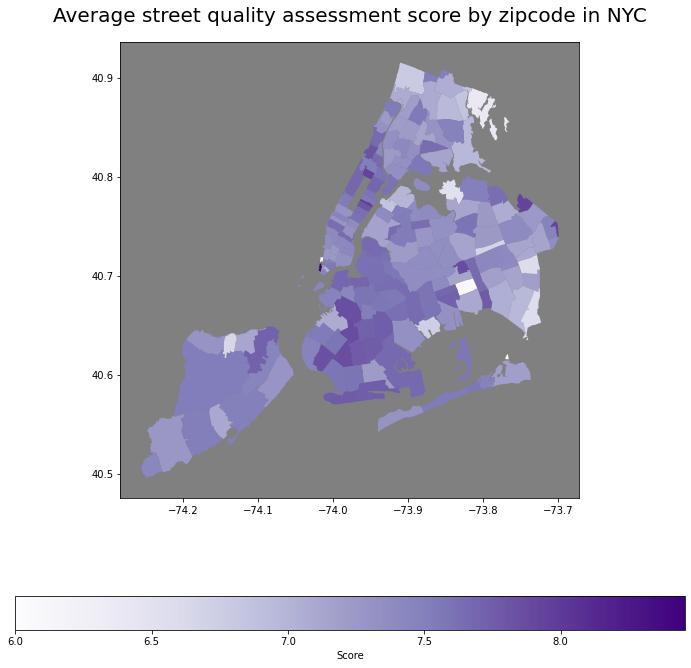

In [ ]:
#plot all zipcodes by their average street segment quality score
fig, ax = plt.subplots(1, 1, figsize=(12,12))

ax.set_aspect('equal')
ax.set_facecolor('grey')
plt.title("Average street quality assessment score by zipcode in NYC", pad=20, fontsize=20)
nyc_acs_sar.plot(ax=ax,
                 column='Rating_B',
                 cmap='Purples',
                 legend=True,
                 legend_kwds={'label': 'Score', 'orientation': 'horizontal'})
plt.savefig('nyc_acs_sar_v5.png')
plt.show()

In [ ]:
Part 1b: bar chart of average street score per borough

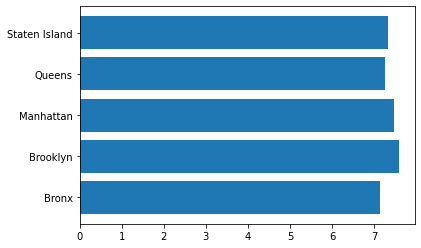

In [ ]:
#bar chart of average street score per borough
fig, ax = plt.subplots()
avg_score = ax.barh(sar_borough_mean.index, sar_borough_mean)
plt.show()

Part 2a: average year of streets quality assessed by zipcode

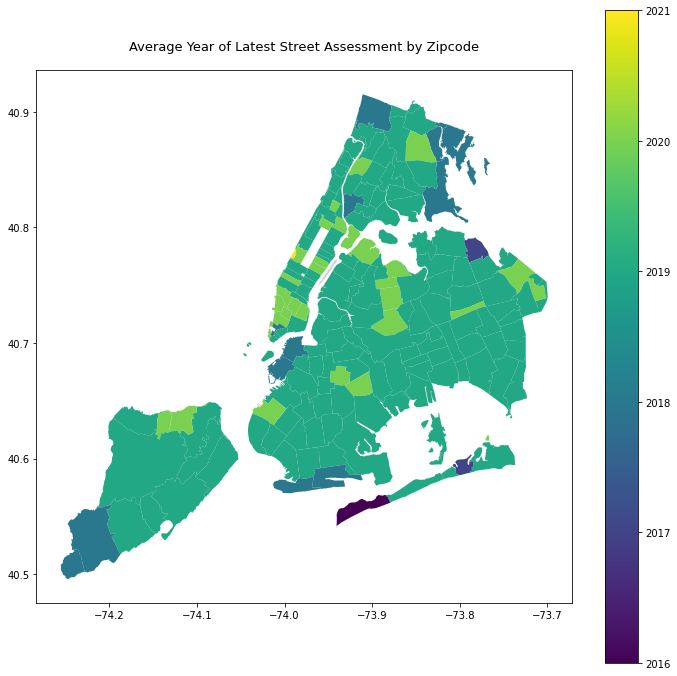

In [ ]:
#plot all zipcodes by the average of the years their streets were last inspected
fig, ax = plt.subplots(figsize=(12,12))
missing_kwds = dict(color='lightgrey', label='No Data')
#ax.set_aspect('equal')
#ax.set_facecolor('white')
plt.title('Average Year of Latest Street Assessment by Zipcode', pad=20, fontsize=13)
nyc_acs_sar.plot(ax=ax,
                 column='RatingFY_SA',
                 #scheme='Quantiles',
                 #k=2,
                 legend=True,
                 missing_kwds=missing_kwds)
#plt.savefig('nyc_acs_sar_v6.png')
plt.show()

Part 2b: bar chart of average year of street assessment per borough

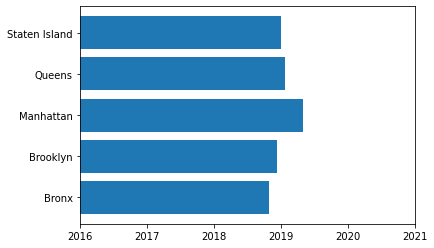

In [ ]:
#bar chart of average street assessment year by borough
fig, ax = plt.subplots()
avg_year = ax.barh(sar_borough_year_mean.index, sar_borough_year_mean)
ax.set_xlim(2016, 2021)
plt.show()

Part 3: diverging bar chart
Compares median income of each zipcode to its street quality score

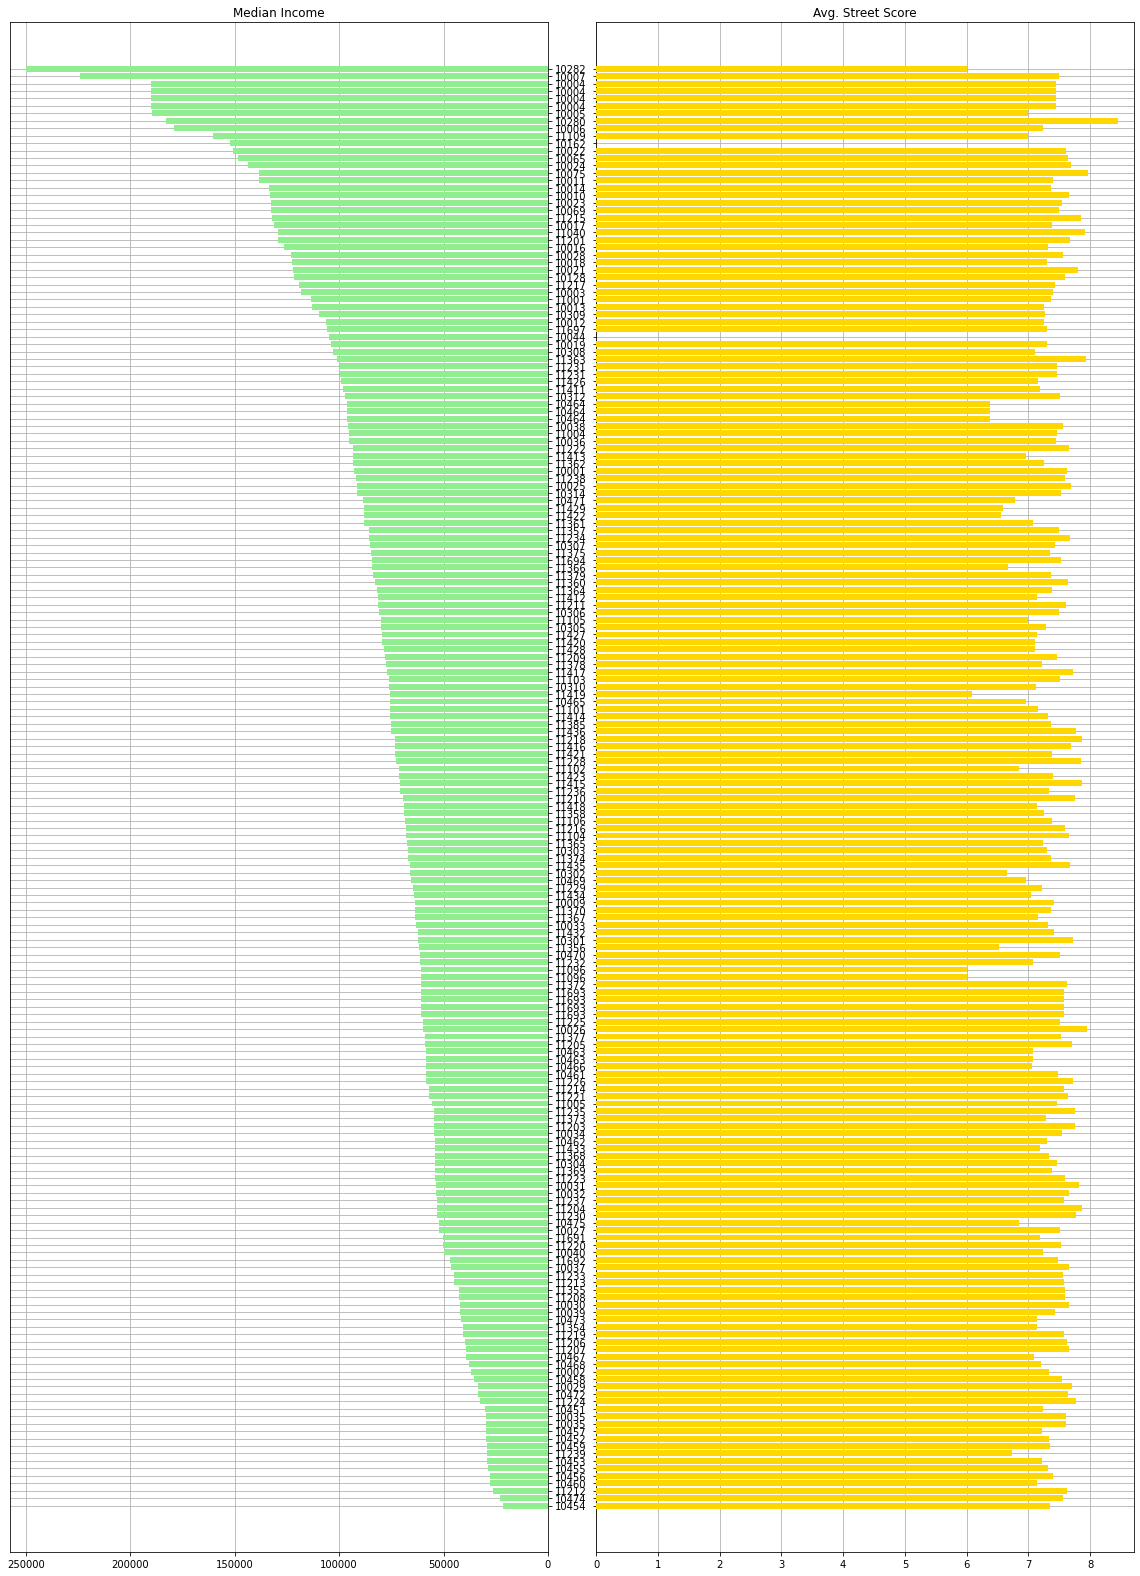

In [ ]:
#diverging bar chart of zip codes ranked by median income (desc)
#with each zipcodes street score on the right bar

#shared y-axis
zips = zips_st_scores3['zip']

#x1 axis
income = zips_st_scores3['median_income']
#x2 axis
score = zips_st_scores3['Rating_B']
#sort income
idx = income.argsort()
#set all three axes to the same index
zips, income, score = [np.take(x, idx) for x in [zips, income, score]]
#set y to appropriate range
y = np.arange(score.size)

#bar plot of the zipcodes street assessment scores
fig, axes = plt.subplots(ncols = 2, sharey = True, figsize =  (16,22))
axes[0].barh(y, income, align = 'center', color = 'lightgreen', zorder = 10)    #income barplot
axes[0].set(title = 'Median Income')
axes[1].barh(y, score, align = 'center', color = 'gold', zorder = 10)
axes[1].set(title = 'Avg. Street Score')

axes[0].invert_xaxis()
axes[0].set(yticks = y, yticklabels = zips)
axes[0].yaxis.tick_right()

for ax in axes.flat:
  ax.margins(0.03)
  ax.grid(True)

fig.tight_layout()
fig.subplots_adjust(wspace = 0.09)
plt.savefig('income_vs_score.png')
plt.show()

Part 4: normalized variable scatterplots

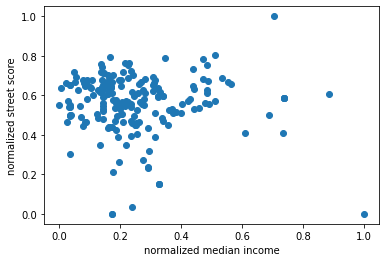

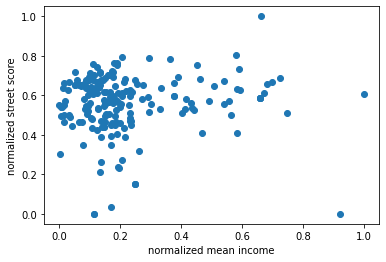

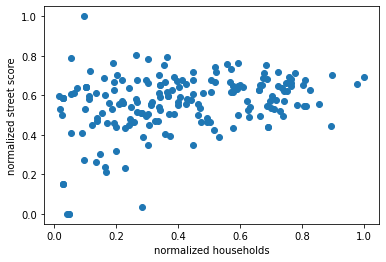

In [ ]:
#scatter plot of street score to 3 other variables:
#median income (per zip)
#mean income (per zip)
#total households (per zip)

#plot median income vs. street score

inc = norm(zips_st_scores3['median_income'])
sc = norm(zips_st_scores3['Rating_B'])

plt.scatter(x=inc, y=sc)
plt.xlabel("normalized median income")
plt.ylabel("normalized street score")
plt.show()

#plot mean income vs. street score
zips_st_scores3['mean_income'] = zips_st_scores3['mean_income'].astype(int)     #convert column to int datatype
mean_inc = norm(zips_st_scores3['mean_income'])

plt.scatter(x=mean_inc, y=sc)
plt.xlabel("normalized mean income")
plt.ylabel("normalized street score")
plt.show()

#plot total households vs. street score
zips_st_scores3['total_households'] = zips_st_scores3['total_households'].astype(int) #convert column to int datatype
hshld = norm(zips_st_scores3['total_households'])

plt.scatter(x=hshld, y=sc)
plt.xlabel("normalized households")
plt.ylabel("normalized street score")
plt.show()

Part 5: web map visualization

5a: create non-na copy dataframe for map plotting

In [ ]:
zips_st_scores_nona = zips_st_scores3                                           #create copy dataframe with 0 values for two nan scores
zips_st_scores_nona['Rating_B'] = zips_st_scores_nona['Rating_B'].fillna(0)     #to allow for map visual (will not render with nan values)

#convert year assessed column to str so years dont display as "0,000"
st_ln_score_wgs['RatingFY_SA'] = st_ln_score_wgs['RatingFY_SA'].astype(str)

5b: geodataframe creation for highlighted zipcodes

In [ ]:
#create 4 zipcode level street segment geodataframes:
geo_11224 = st_ln_score_wgs[st_ln_score_wgs['zip'] == '11224']                  #highlights a lower-income, higher-scoring streets ZIP
geo_11239 = st_ln_score_wgs[st_ln_score_wgs['zip'] == '11239']                  #highlights a lower-income, lower-scoring streets ZIP
geo_10282 = st_ln_score_wgs[st_ln_score_wgs['zip'] == '10282']                  #highlights a higher-income, lower-scoring streets ZIP
geo_11040 = st_ln_score_wgs[st_ln_score_wgs['zip'] == '11040']                  #highlights a higher-income, higher-scoring streets ZIP
geo_11419 = st_ln_score_wgs[st_ln_score_wgs['zip'] == '11419']                  #lowest street quality score ZIP
geo_10280 = st_ln_score_wgs[st_ln_score_wgs['zip'] == '10280']                  #highest street quality score ZIP


#create 'index' column to set reference to unique index for later colormapping
geo_11224['index'] = geo_11224.index
geo_11239['index'] = geo_11239.index
geo_10282['index'] = geo_10282.index
geo_11040['index'] = geo_11040.index
geo_11419['index'] = geo_11419.index
geo_10280['index'] = geo_10280.index

5c: colormapping / folium web map

In [ ]:
#web map visualization of street segment scores by ZIP

#first calculate appropriate min and max color values because the street
#score data is not evenly spread
#sets the min and max values to either the 5% or 95% quantiles of the data
min, max = zips_st_scores3['Rating_B'].quantile([0.05, 0.95]).apply(lambda x: round(x, 2))
#find the overall mean of the street scores for all zipcodes
mean = round(zips_st_scores3['Rating_B'].mean(),2)
#test print
print(f"Min: {min}", f"Max: {max}", f"Mean: {mean}", sep="\n\n")

#colormap creation using ColorBrewer color palette - FOR FULL ZIPCODE LEVEL
colormap = branca.colormap.LinearColormap(
    colors = ['#ffffcc', '#c2e699', '#78c679', '#31a354', '#006837'],
    index = zips_st_scores3['Rating_B'].quantile([0.2, 0.4, 0.6, 0.8]),
    vmin = min,
    vmax = max
)

colormap.caption = "Average Street Quality Score"

colormap
#colormap for street segments - FOR INDIVIDUAL STREET SEGMENTS
street_color = branca.colormap.LinearColormap(
    colors = ['#ffffcc', '#c2e699', '#78c679', '#31a354', '#006837'],
    vmin = 1.0,
    vmax = 10.0,
)

street_color

#function to assign colors to each of the zips streets scores and assign
#grey colors to the two zips that don't have any assessed streets

map_dict = zips_st_scores_nona.set_index('zip')['Rating_B'].to_dict()           #dictionary of zips and their avg street scores

def set_color(feature):                                                         #set colors of all zipcodes
  value = map_dict.get(feature['properties']['zip'])
  if value == 0.0:
    return '#8c8c8c'
  else:
    return colormap(value)

street_dict_11224 = geo_11224.set_index(geo_11224.index)['Rating_B'].to_dict()  #dictionary of each zips row index / street score
street_dict_11239 = geo_11239.set_index(geo_11239.index)['Rating_B'].to_dict()  #to be able to set colors to street segments
street_dict_10282 = geo_10282.set_index(geo_10282.index)['Rating_B'].to_dict()
street_dict_11040 = geo_11040.set_index(geo_11040.index)['Rating_B'].to_dict()
street_dict_11419 = geo_11419.set_index(geo_11419.index)['Rating_B'].to_dict()
street_dict_10280 = geo_10280.set_index(geo_10280.index)['Rating_B'].to_dict()

def set_street_color(feature, d):                                               #set colors of street segments
  value = d.get(feature['properties']['index'])
  return street_color(value)


map = folium.Map(
      location = [40.7003, -73.9374],
      tiles='cartodbpositron',
      zoom_start = 10,
      )
street_score = folium.GeoJson(zips_st_scores_nona,
                              name = "Street Scores",
                              style_function = lambda feature: {'fillColor': set_color(feature),
                                                                'weight': 1,
                                                                'fillOpacity': 0.5},
                              tooltip = folium.GeoJsonTooltip(fields = ['zip', 'Rating_B', 'median_income', 'pct1',
                                                                        'pct2', 'pct3', 'pct4', 'pct5', 'pct6', 'pct7',
                                                                        'pct8', 'pct9', 'pct10'],
                                                              aliases = ['Zipcode:', 'Avg. Score:', 'Med. income:',
                                                                         '% scoring 1:', '2:', '3:', '4:', '5:', '6:',
                                                                         '7:', '8:', '9:', '10:'],
                                                              localize = True)
                ).add_to(map)

#add layers for 6 different profiles of zip codes to view their streets:
#1. lower income, higher quality streets - 11224
coney_island = folium.GeoJson(geo_11224,
                              name = "11224 - Coney Island",
                              style_function = lambda feature: {'color': set_street_color(feature, street_dict_11224)},
                              tooltip = folium.GeoJsonTooltip(fields = ['Rating_B'],
                                                              aliases = ['Score:'],
                                                              localize = True),
                              show = False,
                              ).add_to(map)
#2. lower income, lower quality streets - 11239
starrett_city = folium.GeoJson(geo_11239,
                               name = "11239 - Starrett City",
                               style_function = lambda feature: {'color': set_street_color(feature, street_dict_11239)},
                               tooltip = folium.GeoJsonTooltip(fields = ['Rating_B'],
                                                               aliases = ['Score:'],
                                                               localize = True),
                               show = False,
                               ).add_to(map)
#3. higher income, lower quality streets - 10282
teardrop_park = folium.GeoJson(geo_10282,
                               name = "10282 - Teardrop Park",
                               style_function = lambda feature: {'color': set_street_color(feature, street_dict_10282)},
                               tooltip = folium.GeoJsonTooltip(fields = ['Rating_B'],
                                                               aliases = ['Score:'],
                                                               localize = True),
                               show = False,
                               ).add_to(map)
#4. higher income, higher quality streets - 11040
hillside_manor = folium.GeoJson(geo_11040,
                                name = "11040 - Hillside Manor",
                                style_function = lambda feature: {'color': set_street_color(feature, street_dict_11040)},
                                tooltip = folium.GeoJsonTooltip(fields = ['Rating_B'],
                                                                aliases = ['Score:'],
                                                                localize = True),
                                show = False,
                                ).add_to(map)
#5. lowest street score zipcode - 11419
morris_park = folium.GeoJson(geo_11419,
                             name = "11419 - Morris Park",
                             style_function = lambda feature: {'color': set_street_color(feature, street_dict_11419)},
                             tooltip = folium.GeoJsonTooltip(fields = ['Rating_B'],
                                                             aliases = ['Score:'],
                                                             localize = True),
                             show = False,
                             ).add_to(map)
#6. highest street score zipcode - 10280
battery_park = folium.GeoJson(geo_10280,
                              name = "10280 - Battery Park City",
                              style_function = lambda feature: {'color': set_street_color(feature, street_dict_10280)},
                              tooltip = folium.GeoJsonTooltip(fields = ['Rating_B'],
                                                              aliases = ['Score:'],
                                                              localize = True),
                              show = False,
                              ).add_to(map)

#search control for zipcodes
zip_search = Search(layer = street_score,
                    geom_type = "Line",
                    placeholder = "Enter a zipcode",
                    collapsed = False,
                    search_label = 'zip',
                    weight = 3
                    ).add_to(map)

folium.LayerControl().add_to(map)
colormap.add_to(map)
#map.save('nyc_street_quality_zip_level_FINAL.html')
#map

Min: 6.55

Max: 7.83

Mean: 7.3


In [ ]:
#folium map of all streets segments colored by score (by borough)

#create borough-specific geodataframes of street segments:
geo_manhattan = st_ln_score_wgs[st_ln_score_wgs['borough'] == 'Manhattan']
geo_bronx = st_ln_score_wgs[st_ln_score_wgs['borough'] == 'Bronx']
geo_brooklyn = st_ln_score_wgs[st_ln_score_wgs['borough'] == 'Brooklyn']
geo_staten = st_ln_score_wgs[st_ln_score_wgs['borough'] == 'Staten Island']
geo_queens = st_ln_score_wgs[st_ln_score_wgs['borough'] == 'Queens']

#add index columns
geo_manhattan['index'] = geo_manhattan.index
geo_bronx['index'] = geo_bronx.index
geo_brooklyn['index'] = geo_brooklyn.index
geo_staten['index'] = geo_staten.index
geo_queens['index'] = geo_queens.index

#dictionaries of index/street scores for colormapping
dict_manhattan = geo_manhattan.set_index(geo_manhattan.index)['Rating_B'].to_dict()
dict_bronx = geo_bronx.set_index(geo_bronx.index)['Rating_B'].to_dict()
dict_brooklyn = geo_brooklyn.set_index(geo_brooklyn.index)['Rating_B'].to_dict()
dict_staten = geo_staten.set_index(geo_staten.index)['Rating_B'].to_dict()
dict_queens = geo_queens.set_index(geo_queens.index)['Rating_B'].to_dict()

nyc = folium.Map(
      location = [40.7003, -73.9374],
      tiles='cartodbpositron',
      zoom_start = 10,
      prefer_canvas = True,
      )

#add layers for 5 boroughs:
#1. manhattan
manhattan = folium.GeoJson(geo_manhattan,
                              name = "Manhattan",
                              style_function = lambda feature: {'color': set_street_color(feature, dict_manhattan)},
                              tooltip = folium.GeoJsonTooltip(fields = ['Rating_B', 'RatingFY_SA'],
                                                              aliases = ['Score:', 'Year assessed:'],
                                                              localize = True),
                              show = False,
                              ).add_to(nyc)
#2. bronx
bronx = folium.GeoJson(geo_bronx,
                               name = "The Bronx",
                               style_function = lambda feature: {'color': set_street_color(feature, dict_bronx)},
                               tooltip = folium.GeoJsonTooltip(fields = ['Rating_B', 'RatingFY_SA'],
                                                               aliases = ['Score:', 'Year assessed:'],
                                                               localize = True),
                               show = False,
                               ).add_to(nyc)
#3. brooklyn
brooklyn = folium.GeoJson(geo_brooklyn,
                               name = "Brooklyn",
                               style_function = lambda feature: {'color': set_street_color(feature, dict_brooklyn)},
                               tooltip = folium.GeoJsonTooltip(fields = ['Rating_B', 'RatingFY_SA'],
                                                               aliases = ['Score:', 'Year assessed:'],
                                                               localize = True),
                               show = False,
                               ).add_to(nyc)
#4. staten island
staten = folium.GeoJson(geo_staten,
                                name = "Staten Island",
                                style_function = lambda feature: {'color': set_street_color(feature, dict_staten)},
                                tooltip = folium.GeoJsonTooltip(fields = ['Rating_B', 'RatingFY_SA'],
                                                                aliases = ['Score:', 'Year assessed:'],
                                                                localize = True),
                                show = False,
                                ).add_to(nyc)
#5. queens
queens = folium.GeoJson(geo_queens,
                                name = "Queens",
                                style_function = lambda feature: {'color': set_street_color(feature, dict_queens)},
                                tooltip = folium.GeoJsonTooltip(fields = ['Rating_B', 'RatingFY_SA'],
                                                                aliases = ['Score:', 'Year assessed:'],
                                                                localize = True),
                                show = False,
                                ).add_to(nyc)
#layer control
folium.LayerControl().add_to(nyc)

In [ ]:
#save map as html to render in browser (can't load in CoLab environment)
#nyc.save('nyc_street_quality.html')